Limpeza dos dados

In [ ]:
import re
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm  # Importando a barra de progresso
from torch.nn.functional import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [39]:
#Pre processamento dos dados
df = pd.read_excel("indeed_jobs_big.xlsx")
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

df['cleaned_content'] = df['content'].apply(preprocess_text)
df.pop('content')
df.rename(columns={'cleaned_content': 'content'}, inplace=True)
print(df.head())
df.to_excel('dataset_preprocessed.xlsx', index=False)

                                               title  \
0  Visagio Talentos - Estágio: Desenvolvedor(a) d...   
1                                  Desenvolvedor PHP   
2                       Desenvolvedor de Software Jr   
3                       Desenvolvedor(a) de Software   
4                           Desenvolvedor Full Stack   

                                             content  
0  destinado a universitários dos cursos de ciênc...  
1  modelo de atuação: 100% remota segunda a sexta...  
2  sobre nós: fundada em 1998, a gran coffee dese...  
3  estamos contratando um(a) desenvolvedor(a) de ...  
4  será responsável por projetar, desenvolver, te...  


In [47]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_bert_embedding(text):
    if not isinstance(text, str) or text.strip() == "":
        return None

    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state
    
    embedding = torch.mean(last_hidden_states, dim=1).squeeze()
    return embedding

embeddings_list = []

for text in tqdm(df['content'], desc="Processando Embeddings"):
    embedding = get_bert_embedding(str(text)) if pd.notnull(text) else None
    embeddings_list.append(embedding)

df_novo = pd.read_excel("dataset_preprocessed.xlsx")

df_novo['bert_embedding'] = embeddings_list

embeddings_matrix = torch.stack([emb for emb in df_novo['bert_embedding'] if emb is not None])

print("Dimensão dos embeddings:", embeddings_matrix.shape)

torch.save(embeddings_matrix, 'bert_embeddings.pt')

Processando Embeddings: 100%|██████████| 1003/1003 [07:37<00:00,  2.19it/s]

Dimensão dos embeddings: torch.Size([992, 768])


In [67]:
embeddings_matrix = torch.load('bert_embeddings.pt')

input_text = "dados"
input_embedding = get_bert_embedding(input_text.lower())

cosine_similarities = cosine_similarity(input_embedding.unsqueeze(0), embeddings_matrix).squeeze()

top_k = 10
top_k_indices = torch.topk(cosine_similarities, top_k).indices

print("Top 10 conteúdos mais similares ao texto de entrada:")
for idx in top_k_indices.tolist():
    similarity_score = cosine_similarities[idx].item()
    content = df.loc[idx, 'content']
    title = df.loc[idx, 'title']
    print(f"\nTítulo: {title}")
    print(f"Similaridade: {similarity_score:.4f}")
    print(f"Conteúdo:\n{content}")

C:\Users\Henri\AppData\Local\Temp\ipykernel_10104\1112106287.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_matrix = torch.load('bert_embeddings.pt')


Top 10 conteúdos mais similares ao texto de entrada:

Título: Desenvolvedor Databricks
Similaridade: 0.7370
Conteúdo:
na stefanini, acreditamos no poder da colaboração. co-criamos soluções inovadoras em parceria com nossos clientes, combinando tecnologia de ponta, inteligência artificial e a criatividade humana. estamos na vanguarda da resolução de problemas de negócios, proporcionando impacto real em escala global. ao se juntar à stefanini, você se torna parte de uma jornada global de transformação. estamos empenhados em criar impacto positivo não apenas nos negócios, mas também na vida de nossos colaboradores. se você procura uma oportunidade de crescimento profissional em uma empresa que valoriza inovação, respeito, autonomia e parceria, você encontra aqui! junte-se a nós e seja parte da mudança! diferenciais: modelo de contratação: clt stefanini modelo de atuação: 100% remoto o que te oferecemos: vale alimentação ou vale refeição; desconto em cursos, universidades e instituições de

pca = PCA(n_components=600)
X_pca = pca.fit_transform(embeddings_matrix)

tsne_pca = TSNE(n_components=2, random_state=42)
X_tsne_pca = tsne_pca.fit_transform(X_pca)

tsne_embeddings = TSNE(n_components=2, random_state=42)
X_tsne_embeddings = tsne_embeddings.fit_transform(embeddings_matrix)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_tsne_pca[:, 0], X_tsne_pca[:, 1], c='blue', label='PCA-reduced')
plt.title('TSNE of PCA-reduced Embeddings')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_tsne_embeddings[:, 0], X_tsne_embeddings[:, 1], c='red', label='Original Embeddings')
plt.title('TSNE of Original Embeddings')
plt.legend()

plt.show()

class Autoencoder(nn.Module):
    def __init__(self, embedding_dim):
        super(Autoencoder, self).__init__()
        # Encoder: reduz dimensionalidade
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        # Decoder: reconstrói as informações
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [61]:
class Autoencoder(nn.Module):
    def __init__(self, embedding_dim):
        super(Autoencoder, self).__init__()
        # Encoder: reduz dimensionalidade
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        # Decoder: reconstrói as informações
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Parâmetros
embedding_dim = embeddings_matrix.shape[1]
autoencoder = Autoencoder(embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Treinamento do Autoencoder
num_epochs = 4
for epoch in range(num_epochs):
    for embedding in embeddings_matrix:
        # Forward pass
        reconstructed = autoencoder(embedding)
        loss = criterion(reconstructed, embedding)
        
        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Extraindo embeddings ajustados
adjusted_embeddings = [autoencoder.encoder(emb).detach() for emb in embeddings_matrix]
torch.save(torch.stack(adjusted_embeddings), 'adjusted_bert_embeddings.pt')

Epoch [1/4], Loss: 0.013617408461868763
Epoch [2/4], Loss: 0.01046666782349348
Epoch [3/4], Loss: 0.009177379310131073
Epoch [4/4], Loss: 0.004564859438687563


In [65]:
new_embeddings_matrix = torch.load('adjusted_bert_embeddings.pt')
input_text = "dados"
input_embedding = get_bert_embedding(input_text.lower())
input_embedding_reduced = autoencoder.encoder(input_embedding.unsqueeze(0)).detach()
cosine_similarities = cosine_similarity(input_embedding_reduced, new_embeddings_matrix).squeeze()

top_k = 10
top_k_indices = torch.topk(cosine_similarities, top_k).indices

print("Top 10 conteúdos mais similares ao texto de entrada:") 
for idx in top_k_indices.tolist():
    similarity_score = cosine_similarities[idx].item()
    content = df.loc[idx, 'content']
    title = df.loc[idx, 'title']
    print(f"\nTítulo: {title}")
    print(f"Similaridade: {similarity_score:.4f}")
    print(f"Conteúdo:\n{content}")

C:\Users\Henri\AppData\Local\Temp\ipykernel_10104\4139771614.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_embeddings_matrix = torch.load('adjusted_bert_embeddings

Top 10 conteúdos mais similares ao texto de entrada:

Título: Desenvolvedor Databricks
Similaridade: 0.9433
Conteúdo:
na stefanini, acreditamos no poder da colaboração. co-criamos soluções inovadoras em parceria com nossos clientes, combinando tecnologia de ponta, inteligência artificial e a criatividade humana. estamos na vanguarda da resolução de problemas de negócios, proporcionando impacto real em escala global. ao se juntar à stefanini, você se torna parte de uma jornada global de transformação. estamos empenhados em criar impacto positivo não apenas nos negócios, mas também na vida de nossos colaboradores. se você procura uma oportunidade de crescimento profissional em uma empresa que valoriza inovação, respeito, autonomia e parceria, você encontra aqui! junte-se a nós e seja parte da mudança! diferenciais: modelo de contratação: clt stefanini modelo de atuação: 100% remoto o que te oferecemos: vale alimentação ou vale refeição; desconto em cursos, universidades e instituições de

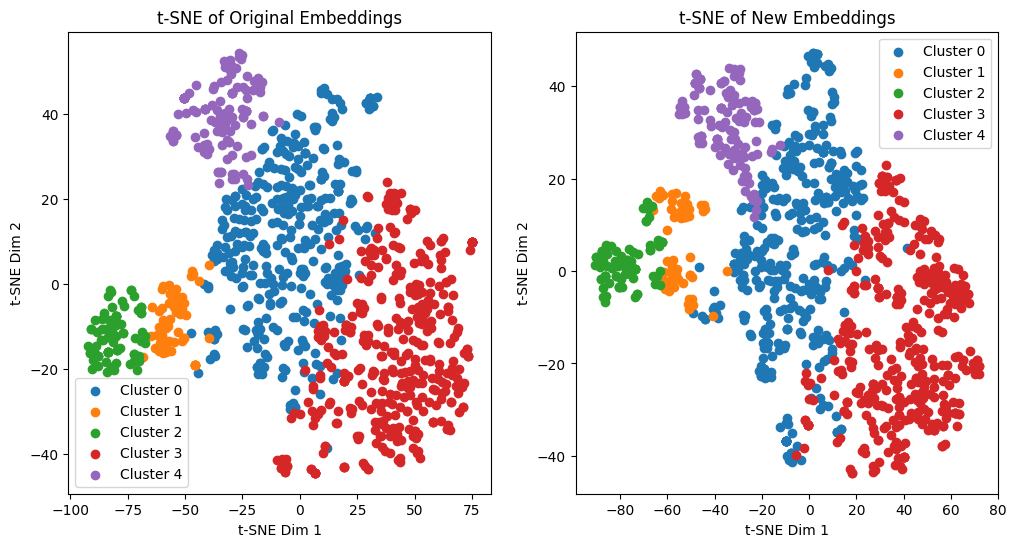

In [72]:
# Apply t-SNE to the original embeddings
tsne_original = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_original = tsne_original.fit_transform(embeddings_matrix)

# Apply t-SNE to the new embeddings
tsne_new = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_new = tsne_new.fit_transform(new_embeddings_matrix)

# Converter embeddings para um formato utilizável com o t-SNE
embeddings_np = embeddings_matrix.numpy()  # Transforma o tensor PyTorch em array NumPy

# Opcional: usar KMeans para agrupar embeddings e identificar clusters
n_clusters = 5  # Altere para o número de clusters que deseja
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)

# Plot the t-SNE results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for cluster_id in range(n_clusters):
    # Selecionar pontos pertencentes ao cluster atual
    cluster_points = X_tsne_original[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')
plt.title('t-SNE of Original Embeddings')
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()

plt.subplot(1, 2, 2)
for cluster_id in range(n_clusters):
    # Selecionar pontos pertencentes ao cluster atual
    cluster_points = X_tsne_new[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')
plt.title('t-SNE of New Embeddings')
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()

plt.show()